# Optimizing Models and Using AutoML

How to choose between models and how to optimize
models.

- Hyperparameter optimization with random, grid, and Bayesian searches
- Using learning curves to optimize the amount of data needed and diagnose ML models
- Optimizing the number of features with recursive feature selection
- Using the AutoML Python package pycaret



## Hyperparameter optimization with search methods

Hyperparameters are settings for the models that we choose, while
parameters are values the models learn (like the coefficients for linear or logistic
regression). Arguments provided to functions in Python and programming are
also called parameters.

We've also seen how there are cross-validation (CV) classes for linear and logistic
regression in sklearn that allow us to optimize the C or alpha hyperparameter for
regularization strength. However, these built-in CV methods only search for one
optimum hyperparameter and don't have to worry about multiple hyperparameters
at once. When we introduce more than one hyperparameter to optimize, things get
more complex.

An example is the KNN algorithm, which makes predictions by averaging the
k nearest points to a datapoint. From the sklearn documentation for the regression
version of KNN (https://scikit-learn.org/stable/modules/generated/
sklearn.neighbors.KNeighborsRegressor.html), we can see there are several
hyperparameters we could tune:

- n_neighbors
- weights
- p (the Minkowski distance power parameter)
- Others including algorithm, leaf_size, metric, and metric_params

The Minkowski distance is a general formula for the distance between two points.
When p is 2, this is the Euclidean distance (straight line distance); when p is 1, it is the
Manhattan or city block distance.

Methods for tuning ML algorithm with many hyperparameters:
- Random Search
- Grid Search
- Bayesian Search and other advanced search methods

These all take a defined hyperparameter space and search it in different ways.
The random search, as the name implies, randomly tries different combinations
of hyperparameters. Grid search methodically tries all combinations of
hyperparameters we provide. Finally, Bayesian search uses Bayesian statistical
principles to more efficiently search a hyperparameter space. There are several
other advanced search methods, including the Hyperband, Tree-structured Parzen
Estimator (TPE), and the CMA-ES algorithms implemented in the optuna and other
Python packages.

For CV, we break up our data into n parts,
where a common value for n might be 3 or 5. We can also stratify our data (if we are
doing classification) so that the balance of classes is the same between the different
parts. Then we train an ML model on all of the parts except one. The dataset that
was left out of the training is called the hold-out, validation, or test set, and we
evaluate the model's performance on this test set to understand how it performs.
Then we do this for all possible combinations of the data. For n-fold CV, we have
n combinations. Finally, we average the scores on the test sets to arrive at an overall
score. With hyperparameter searches, we do this process for each combination of
hyperparameters and choose the combination with the best score.

In [1]:
import pandas as pd

df_file_path = "https://raw.githubusercontent.com/PacktPublishing/Practical-Data-Science-with-Python/main/14-Chapter-14/data/housing_data_sample.csv"

df = pd.read_csv(df_file_path, index_col="Id")

df.head()

,LotArea,YearBuilt,FullBath,TotRmsAbvGrd,GarageArea,1stFlrSF,2ndFlrSF,SalePrice
Id,,,,,,,,
1,8450,2003,2,8,548,856,854,208500
2,9600,1976,2,6,460,1262,0,181500
3,11250,2001,2,6,608,920,866,223500
4,9550,1915,1,7,642,961,756,140000
5,14260,2000,2,9,836,1145,1053,250000


> This is a regression problem, but
the techniques we will cover work just as well for classification. We will only be
using the KNN model in our demonstrations, but of course this works for other
ML models with hyperparameters as well.

## Using Grid Search

To use grid search, we can use a built-in sklearn class: GridSearchCV. We need to
define an ML model and set of hyperparameters first:

In [2]:
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor()

hyperparameters = {"n_neighbors": [3, 5, 7],
                   "weights": ["uniform", "distance"],
                   "p": [1,2]
                }



We first import the KNN regressor model and initialize it, then we create
a dictionary of hyperparameters. Each key in the dictionary is a parameter for
the ML model class, and the values are lists of values to try. We can then use
the GridSearchCV class to find the optimal combination of hyperparameters:

In [3]:
from sklearn.model_selection import GridSearchCV

features = df.drop("SalePrice", axis=1)

targets = df["SalePrice"]

gs = GridSearchCV(knn,
                 hyperparameters,
                 scoring = "neg_mean_absolute_error",
                  n_jobs = -1
                 )

gs.fit(features, targets)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

We first import the grid search class, then create our features and targets from
our DataFrame. Next, we initialize the grid search class with our KNN model (we
could also put the KNeighborsRegressor() class instantiation call there directly), our
dictionary of hyperparameters, a scoring metric, and the number of processors to use
(-1 for n_jobs specifies to use all available CPUs). Notice we are specifying a custom
scoring metric here, which is the negative value of the mean absolute error (MAE).
The default scoring metric for regression models in sklearn is R2 but using RMSE
or MAE can be a little easier to interpret and explain.

Finally, we call the fit method on features and targets, which performs CV on the
data with each combination of hyperparameters. By default, it uses 5-fold stratified
CV (the stratification only matters for classification, and keeps the proportion of
different classes the same between train and test sets). We can change the number
of CV splits with the cv parameter for GridSearchCV by providing a number. Grid
search tries every possible combination of the hyperparameters we provide to it.

In [4]:
print(gs.best_estimator_)
print(gs.best_params_)
print(gs.best_score_)

KNeighborsRegressor(n_neighbors=7, p=1, weights='distance')
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
-30067.805981482


We can see from the best score (the last line) that the average error between
predictions and actual values is around $30k. For regression, we want to use
negative values since the grid search here is maximizing the score to find the best
model (it also maximizes the score for classification). We can choose from many
pre-built scores listed in the documentation (https://scikit-learn.org/stable/
modules/model_evaluation.html#scoring-parameter) or we can create our own
scoring metric using the make_scorer function from sklearn. In many cases we will
be able to use one of the pre-built scoring methods. The best_params_ attribute gives
us a dictionary of hyperparameters for the best model, and the best_model_ attribute
gives us the sklearn model we can use to re-train on the full dataset or to make
predictions.

Grid search works well if you know a specific set of hyperparameter you
want to search. However, it exhaustively searches all possible hyperparameter
combinations, which can take a long time for a large dataset or many combinations
of hyperparmeters. It does give us a lot of results of scores for different
hyperparameters, however. We can examine the sets of hyperparameters and their
corresponding CV scores like so:

In [5]:
list(zip(gs.cv_results_["params"], gs.cv_results_["mean_test_score"]))

[({'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}, -31791.80296803653),
 ({'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, -31216.846162311565),
 ({'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}, -32979.52716894977),
 ({'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, -32340.112686733315),
 ({'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}, -31166.12369863013),
 ({'n_neighbors': 5, 'p': 1, 'weights': 'distance'}, -30429.898579313198),
 ({'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}, -31983.19452054795),
 ({'n_neighbors': 5, 'p': 2, 'weights': 'distance'}, -31132.746789491037),
 ({'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}, -30931.227788649703),
 ({'n_neighbors': 7, 'p': 1, 'weights': 'distance'}, -30067.805981482),
 ({'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}, -32122.572113502934),
 ({'n_neighbors': 7, 'p': 2, 'weights': 'distance'}, -31028.72855465766)]

> Which shows that every combination of hyperparameters has been tried:

## Using Random Search

The sklearn random search for hyperparameters operates like grid search, but
we can provide distributions for hyperparameters instead of specific values. For
example, we can specify a uniform distribution between 3 and 20 for n_neighbors:

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


hyperparameters = {"n_neighbors": randint(low=3, high=20),
                   "weights": ["uniform", "distance"],
                   "p": [1, 2]
                  }

rs = RandomizedSearchCV(knn,
                       hyperparameters,
                       scoring = "neg_mean_absolute_error",
                        n_jobs = -1,
                        random_state = 42
                       )

rs.fit(features, targets)

RandomizedSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AD4F885A00>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='neg_mean_absolute_error')

We should use a scipy distribution to specify a distribution for hyperparameters
where we want to try a range but don't want to specify exact values. For
hyperparameters that are integers, we can use randint. We can use the randint,
uniform, loguniform, or other distributions depending on the hyperparameter we are
specifying

For regularization parameters and some others, such as the gamma hyperparameters
for SVMs, a log uniform distribution can work well. This is because regularization
hyperparameters can span orders of magnitude, and a log uniform distribution
can search these orders of magnitude efficiently. For example, we might use
scipy.stats.loguniform(1e-4, 1e4) for C in a logistic regression model. For
something with a smaller potential range, like our number for k in KNN, a uniform
distribution works well (and for an integer hyperparameter, we should use randint).

One of the advantages of the random search is we can limit the number of
hyperparameter combinations we search with the n_iter parameter. Notice that
in the above function we didn't set this and left it at the default of 10. We did set
the random_state parameter so that the results are the same every time we run
the above code. In the same way as our grid search, we can get the best model,
hyperparameters, and score:

In [7]:
print(rs.best_estimator_)
print(rs.best_params_)
print(rs.best_score_)

KNeighborsRegressor(n_neighbors=13, p=1, weights='distance')
{'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
-29848.315066076077


> We can see our n_neighbors is larger and our MAE is a little better than with our
grid search. We can also look at the exact hyperparameters tried like so:

In [8]:
list(zip(rs.cv_results_["params"], gs.cv_results_["mean_test_score"]))

[({'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}, -31791.80296803653),
 ({'n_neighbors': 17, 'p': 1, 'weights': 'distance'}, -31216.846162311565),
 ({'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}, -32979.52716894977),
 ({'n_neighbors': 13, 'p': 1, 'weights': 'distance'}, -32340.112686733315),
 ({'n_neighbors': 6, 'p': 2, 'weights': 'distance'}, -31166.12369863013),
 ({'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}, -30429.898579313198),
 ({'n_neighbors': 4, 'p': 2, 'weights': 'distance'}, -31983.19452054795),
 ({'n_neighbors': 8, 'p': 2, 'weights': 'distance'}, -31132.746789491037),
 ({'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, -30931.227788649703),
 ({'n_neighbors': 14, 'p': 1, 'weights': 'uniform'}, -30067.805981482)]

We can see how these are random samples for n_neighbors. The random search
takes a random sample from distributions or values provided for hyperparameters.
We can also see with a smaller search space some hyperparameter combinations are
repeated exactly in some of the trials. Again, this method is advantageous for larger
hyperparameter search spaces and larger datasets where a grid search would take
too long to run.

## Using Bayesian Search

Bayesian search for hyperparameters searches the hyperparameter space and
computes scores similar to the random search. We choose some random points and
calculate the scores. However, it then approximates the scoring space in between
these known points and uses that to guess which hyperparameters will lead to a
better score. One way is to use a Gaussian function to interpolate unknown model
scores with combinations of hyperparameters.

In [9]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

hyperparameters = {"n_neighbors": Integer(3, 20),
                   "weights": Categorical(["uniform", "distance"]),
                   "p" : Categorical([1, 2])
                  }

bs = BayesSearchCV(knn,
                  hyperparameters,
                  scoring="neg_mean_absolute_error",
                   n_jobs=-1,
                   random_state=42,
                   n_iter=10
                  )

bs.fit(features, targets)

BayesSearchCV(estimator=KNeighborsRegressor(), n_iter=10, n_jobs=-1,
              random_state=42, scoring='neg_mean_absolute_error',
              search_spaces={'n_neighbors': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'p': Categorical(categories=(1, 2), prior=None),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

First, we import the BayesSearchCV class as well as some functions for generating
distributions used by skopt. We then create our hyperparameter dictionary. We need
to use the skopt.space search space functions to generate our distributions. Then we
create the Bayesian search object in the same way as we did for the random and grid
searches and set the number of iterations (n_iter) to 10 instead of the default of 100.
We then fit our search object to the features and targets, and can examine the best
model again:

In [10]:
print(bs.best_estimator_)
print(bs.best_params_)
print(bs.best_score_)

KNeighborsRegressor(n_neighbors=11, weights='distance')
OrderedDict([('n_neighbors', 11), ('p', 2), ('weights', 'distance')])
-31144.29534568762


Our result is not quite as good as the random search in this case, but we didn't
search the space very thoroughly. Bayesian search can also be more helpful if we
have hyperparameters that span many orders of magnitude, such as regularization
hyperparameters.

## Other advanced search methods

There are a host of other advanced search methods that can search hyperparameter
spaces in a more efficient and intelligent way than random or grid searches. Some
of the Python packages that implement these methods are:
- tune-sklearn
- optuna
- hyperopt
- hpbandster

These use methods that improve upon random search. In one group of methods,
random search is improved by mathematical approximations of the search
space, such as the Bayesian search we used, TPE, and CMA-ES. The other group
optimizes resource usage, such as using early stopping of training for unpromising
hyperparameter combinations. These methods include successive halving,
Hyperband, median pruning, and other pruning methods. The resource-optimizing
methods require that the ML algorithm can be stopped early or has a warm start
option (such as some sklearn algorithms). Resource-optimizing methods can work
well for neural networks too

## Using Learning Curves

Another part of model optimization is determining the right amount of data to use.
We want to use enough data so that our performance is maximized, but don't want
to use too much extra data if it's not going to improve performance, since that would
take more resources and longer to train. Using the yellowbrick package, we can
easily see how our model's performance changes as we increase the amount of data
we use:

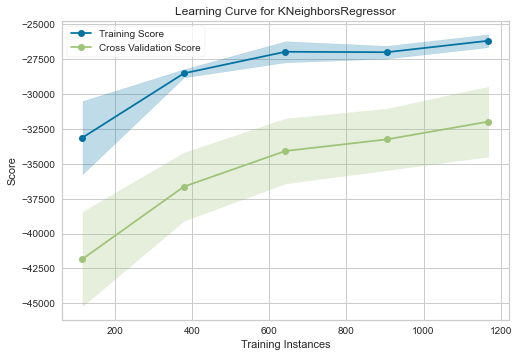

<AxesSubplot:title={'center':'Learning Curve for KNeighborsRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [11]:
from yellowbrick.model_selection import LearningCurve

lc = LearningCurve(knn, scoring="neg_mean_absolute_error")

lc.fit(features, targets)

lc.show()

The training score is the average score on the training sets from CV, while the CV
score is the average score on the validation sets. We also see the bands, which are the
standard deviation of the scores. From our results, it's clear we don't have enough
data – our CV score is increasing even when we use the maximum amount of data.
For better model performance, we should collect more data until the CV score
flattens out.

## Optimizing the number of features with ML models

Another way to optimize our models is to use feature selection with the models. To
do this, we need models that have a coefficient or feature importance aspect, such
as linear regression, logistic regression, or tree-based methods. We can use forward,
backward, or recursive feature selection. Both recursive and backward selection start
with all features, then remove features that are least important.

However, forward or backward selection (sequential selection) fits several models
to select each feature to add or remove, while recursive selection only fits one model
for each feature it removes. For example, the first feature from forward selection
would be found by fitting a model with each feature separately and taking the
model with the best performance. For recursive selection, we fit one model and
remove the feature that is least important (indicated by feature importance or feature
coefficients). After the process, we can get a Boolean mask to select the specified
number of features that gave the best score. We can use recursive feature selection
with CV like so:

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
feature_selector = RFECV(lr, scoring="neg_mean_absolute_error")
feature_selector.fit(features, targets)

RFECV(estimator=LinearRegression(), scoring='neg_mean_absolute_error')

First, we import the recursive feature selection class (RFECV) and the linear
regression model. Then we create our model and feature selection object, using the
negative MAE as our metric. Next, we simply fit the feature selection to our features
and targets. Then we can get an array of our scores:

In [13]:
feature_selector.cv_results_

{'mean_test_score': array([-44963.06493189, -41860.3132655 , -37319.2626792 , -33319.79319284,
        -28524.60411086, -27607.29672974, -27315.23987193]),
 'std_test_score': array([2186.72243697, 2344.77925929, 1832.34705955, 1552.14005033,
        1245.87448017, 1435.81202059, 1602.63601396]),
 'split0_test_score': array([-43875.16384491, -39740.82269388, -35668.51509792, -32005.65847112,
        -28001.8651227 , -26118.6020517 , -25602.78912575]),
 'split1_test_score': array([-44704.82712375, -41025.18585022, -36671.82235718, -33567.38417199,
        -28216.95108909, -27237.94691026, -26853.95932881]),
 'split2_test_score': array([-47881.9594365 , -43881.35515336, -37179.59422766, -31851.39339112,
        -28558.05589858, -27951.53564394, -27597.48046767]),
 'split3_test_score': array([-41636.82154915, -39345.50121505, -36230.35062106, -33023.89121645,
        -27042.3251971 , -26535.1498287 , -26282.54954971]),
 'split4_test_score': array([-46716.55270513, -45308.70141497, -40846.0

The results show an array of scores for a number of selected features, starting from
1 and going up to the maximum number of features in our data (7, here). We can
see as we remove features our score gets worse, so in this case it's best to keep all
features unless we have some other constraint that requires us to remove features
(such as training or prediction runtime). If we do find that the score is better without
some features, we can select the best features like this:

In [14]:
features.iloc[:, feature_selector.support_]

,LotArea,YearBuilt,FullBath,TotRmsAbvGrd,GarageArea,1stFlrSF,2ndFlrSF
Id,,,,,,,
1,8450,2003,2,8,548,856,854
2,9600,1976,2,6,460,1262,0
3,11250,2001,2,6,608,920,866
4,9550,1915,1,7,642,961,756
5,14260,2000,2,9,836,1145,1053
...,...,...,...,...,...,...,...
1456,7917,1999,2,7,460,953,694
1457,13175,1978,2,7,500,2073,0
1458,9042,1941,2,9,252,1188,1152


There is also a `SequentialFeatureSelector` class that is new in sklearn version
0.24 and that behaves similarly with backward feature selection. If we use it with
the default forward selection, it adds one feature at a time by trying all features and
keeping the one with the best score. Both the recursive CV and sequential methods
use 5-fold CV by default.

## Using AutoML with PyCaret

An easier way to try many models at once is with automated machine learning, or AutoML.



### The no free lunch theorem

In ML, we usually don't know which model will perform best. Take our logistic
regression models and Naïve Bayes, and the logistic regression models. We didn't have too many
reasons to know which one might perform best before trying them. Of course,
we know the Gaussian Naïve Bayes assumes features have a normal distribution,
which seemed wrong, so we might guess that model may not work well. We can use
assumptions for models to guess which models may or may not work, but beyond
that, we should try several different models and compare the results, then choose
the best-performing model based on the model evaluation metric we choose.

### AutoML Solutions

AutoML is an idea that has been around since the 1990s but is just starting to emerge
as a widely used technology in the 2020s. Part of this is due to many people making
easy-to-use AutoML tools, such as several AutoML packages in Python:

- PyCaret
- H2O
- TPOT
- mljar-supervised
- AutoGluon
- MLBox
- AutoVIML
- NNI (Neural Network Intelligence)
- Ludwig
- AutoGL (for graph datasets)
- auto-sklearn 
- AutoKeras, AdaNet, and Auto-PyTorch (for neural networks)

Most major cloud providers have AutoML solutions as well, and usually these can
be done with GUIs, Python APIs, or a combination of the two. Three of the biggest
cloud providers, Microsoft's Azure, Amazon's AWS, and Google's GCP, all have
AutoML products available. Other major cloud providers, such as Baidu, also have
AutoML solutions ready. Many data science GUIs have AutoML tools available as
well, including RapidMiner and Weka.


AutoML solutions are still limited – no single AutoML solution tries all available
models, and since new models are being developed all the time, this is difficult if
not impossible to do. However, it's still a quick way to try several models and pick
something better than a default model you might choose. Some of the AutoML
solutions will include extensive feature transformation/engineering and selection,
while others will not.

In [15]:
from pycaret.regression import setup, compare_models

exp_clf = setup(df, target="SalePrice", fold_shuffle=True)


IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:24:48
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Models
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
LotArea,Numeric
YearBuilt,Numeric
FullBath,Categorical
TotRmsAbvGrd,Categorical
GarageArea,Numeric
1stFlrSF,Numeric
2ndFlrSF,Numeric
SalePrice,Label


quit


SystemExit: Read the documentation of setup to learn how to overwrite data types over the inferred types. setup function must run again before you continue modeling.

> In our case, we actually want the number of bedrooms and bathrooms to be numeric,
so we can type quit in the input prompt and re-run the setup like so:

In [16]:
exp_clf = setup(df,
                target='SalePrice',
                numeric_features=['FullBath', 'TotRmsAbvGrd'], imputation_type='iterative',fold_shuffle=True)

,Description,Value
0,session_id,3537
1,Target,SalePrice
2,Original Data,"(1460, 8)"
3,Missing Values,0
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 7)"


Now we have forced those two features to be numeric and can proceed. Note that
there are a huge number of configurations possible with setup that can be accessed
through the function parameters, which are described in the documentation.

Next, when we run best = compare_models(sort='MAE'), pycaret tries several ML
models with default hyperparameters. As it's running in a Jupyter Notebook or
IPython shell, it outputs the results as they become available. The metrics are results
from CV. Note that we told PyCaret to sort our results by MAE, as we've been using
this metric so far. Our results are the following:

In [17]:
best = compare_models(sort="MAE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,21709.9189,1180123402.0687,33209.3608,0.8202,0.1803,0.1319,0.5690
et,Extra Trees Regressor,21946.5299,1238249251.9666,34103.3576,0.8115,0.1828,0.1329,0.0710
rf,Random Forest Regressor,22618.9796,1315799444.1641,35275.6734,0.7970,0.1863,0.1366,0.0900
gbr,Gradient Boosting Regressor,22955.4944,1385974030.0738,35779.3690,0.7916,0.1869,0.1388,0.0290
lightgbm,Light Gradient Boosting Machine,23132.9207,1408981222.7827,36626.3767,0.7827,0.1895,0.1386,0.1800
xgboost,Extreme Gradient Boosting,23738.3381,1338598892.8000,35595.8104,0.7966,0.1935,0.1440,0.0720
br,Bayesian Ridge,27972.0396,2180415332.9709,45152.1414,0.6513,0.2181,0.1626,0.0050
en,Elastic Net,28033.1316,2196243052.8000,45281.5506,0.6485,0.2193,0.1629,0.0060
llar,Lasso Least Angle Regression,28069.4008,2219581453.8075,45457.0285,0.6440,0.2202,0.1630,0.0060
ridge,Ridge Regression,28071.4355,2220636211.2000,45461.0795,0.6438,0.2204,0.1630,0.0050


We can see the top model is CatBoost, which is a type of boosted tree-based model.
Again, you will need to make sure you've installed the full version of pycaret or
installed the packages from requirements.txt or at least catboost and xgboost to
access all available models. It looks like tree-based models are all of the top models,
such as gradient boosting and random forests. We can see it tries several other
models as well. To use our best model to make predictions, we want to use the
predict_model function from PyCaret:

In [18]:
from pycaret.regression import predict_model, save_model, load_model

prediction_df = predict_model(best, data = features)

This will automatically apply any feature transformations that had been done
during model selection, such as categorical to numeric conversions. This returns a
DataFrame with the same features as the input features DataFrame, but now with a
new Label column, which has the predictions. For regression, this simply provides
the numeric prediction. For classification (from the pycaret.classification
module), it provides the Label column with the category prediction and a Score
column with the probability of the predicted label.

Once we have our optimized model, we can save it to a pickle file like so:

In [19]:
save_model(best, 'data\catboost_regressor')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['FullBath',
                                                           'TotRmsAbvGrd'],
                                       target='SalePrice', time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weig...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='SalePrice')),
                 ('fix_perfect', Remove_100(target='SalePrice')),
        

>This saves our best model to the file catboost_regressor.pkl. We can then load it
back with:

In [20]:
cb_model = load_model('data\catboost_regressor')

Transformation Pipeline and Model Successfully Loaded


This is useful if it takes a long time to train and optimize our models and we don't
want to run the compare_models() repeatedly.